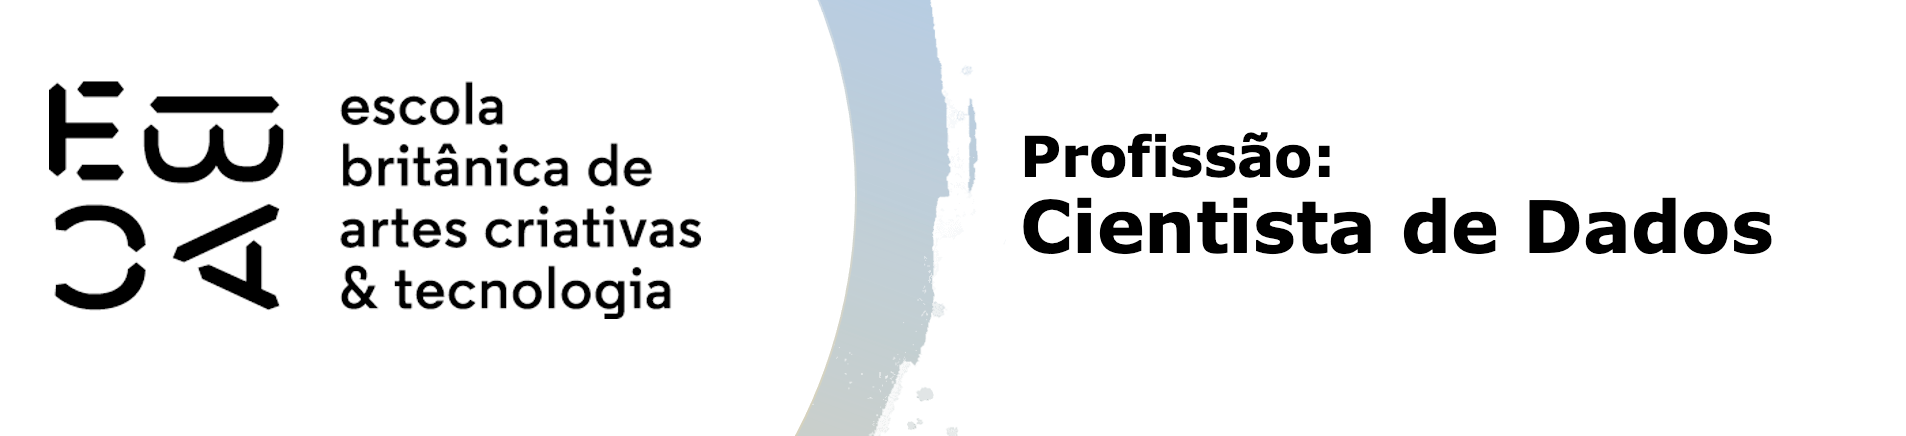

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# dados = pd.read_feather('./Dados/credit_scoring.ftr')
dados = pd.read_feather("C:/Users/Allan/Documents/Material de apoio/Módulo 37 - Regressão Logística II/Dados/credit_scoring.ftr")
display(dados.data_ref.value_counts().sort_values())
display(dados.head())

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
df=dados[(dados['data_ref']>='2016-01-01')].copy()
df.head()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [ ]:
# Contagem das linhas por mês
print("Número de linhas por mês")
print("========================")
display(df['data_ref'].dt.to_period('M').value_counts())

# Descrição básica das variáveis qualitativas
var_ql = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
data_ql = df[var_ql]

for var in var_ql:
    print(f"*** {var} ***")
    print("===="+"="*len(var)+"====")
    display(data_ql[var].value_counts())
    
    print()

# Descrição básica das variáveis quantitativas
var_qt = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
data_qt = df[var_qt]

for var in var_qt:
    print(f"--- {var} ---")
    print("===="+"="*len(var)+"====")
    display(data_qt[var].describe())
    print()

In [ ]:
# Configurações dos gráficos
sns.set(style="dark")

# Gráficos para as variáveis qualitativas
var_ql = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
num_var_ql = len(var_ql)

plt.figure(figsize=(12, 8))
print('V A R I Á V E I S   Q U A L I T A T I V A S'.center(100))
for i, var in enumerate(var_ql):
    plt.subplot(2, (num_var_ql+1)//2, i+1)
    sns.countplot(data=df, x=var)
    # Orientação do label do eixo x
    if var in ['sexo', 'mau','posse_de_veiculo','posse_de_imovel']:
        plt.xticks(rotation=0)
    else:
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Gráficos para as variáveis quantitativas
var_qt = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
num_var_qt = len(var_qt)

plt.figure(figsize=(12, 8))
print('V A R I Á V E I S   Q U A N T I T A T I V A S'.center(100))

for i, var in enumerate(var_qt):
    plt.subplot(2, (num_var_qt+1)//2, i+1)
    sns.histplot(data=df, x=var, kde=True)
#     plt.title(var)
    if var in ['qtd_filhos', 'qt_pessoas_residencia']:
        max_value = df[var].max()
        plt.ylim(0, max_value + 5)  # Definir limite superior do eixo y
    else:
        plt.ylim(0)  # Definir limite inferior do eixo y como 0
#     plt.xticks([])  # Ocultar os valores do eixo x
sns.set(style="whitegrid")
plt.tight_layout()
plt.show()


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [ ]:
print('ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUALITATIVAS'.center(100))
# Configura o tamanho da figura e o número de linhas e colunas dos subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))

# Loop para plotar os gráficos de contagem para as variáveis qualitativas
for i, var in enumerate(var_ql[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.countplot(data=df, x=var, hue='mau')
    plt.title(f'Distribuição de mau pagador por {var}')
    plt.xlabel(var)
    # Orientação do label do eixo x
    if var in ['sexo', 'posse_de_veiculo', 'posse_de_imovel']:
        plt.xticks(rotation=0)
    else:
        plt.xticks(rotation=90)

# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Exibe os gráficos
plt.show()


In [ ]:
print('ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUANTITATIVAS'.center(100))
# Criar um DataFrame apenas com as variáveis contínuas e a variável 'mau'
df_cont = pd.DataFrame({
    'idade': df['idade'],
    'tempo_emprego': df['tempo_emprego'],
    'qt_pessoas_residencia': df['qt_pessoas_residencia'],
    'renda': df['renda'],
    'mau': df['mau']
})

# Plotar o pairplot
sns.pairplot(data=df_cont, hue='mau')

# Exibir o gráfico
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
#Criando metadados
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados

#### Tratamento dos valores missing na coluna 'tempo_emprego'

In [ ]:
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df_nan = df[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df_nan = pd.get_dummies(df_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df_known = df_nan[df_nan['tempo_emprego'].notnull()]
df_unknown = df_nan[df_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df_known.drop('tempo_emprego', axis=1)
y_known = df_known['tempo_emprego']
X_unknown = df_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df_nan.loc[df_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df.loc[df['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df['tempo_emprego'].equals(df_nan['tempo_emprego']):
    display(df.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

In [ ]:
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')
df.mau.value_counts()

In [ ]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [ ]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype']).iloc[2:,:]
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

In [ ]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

### Tratamento das variáveis discretas

In [ ]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(10,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=0)
    
    ax[1] = biv.cont.plot.bar()
    return biv

for i, var in enumerate(var_ql[:-1]):    
    biv_discreta(var, df)

In [ ]:
df2 = df.copy()
df2.tipo_renda.replace({'Bolsista': 'Bolsista/Pensionista', 'Pensionista': 'Bolsista/Pensionista'}, inplace=True)
biv_discreta('tipo_renda', df2)

In [ ]:
df2.educacao.replace({'Pós graduação': 'Sup.Compl+Pós', 'Superior completo': 'Sup.Compl+Pós'}, inplace=True)
biv_discreta('educacao', df2)

In [ ]:
df2.tipo_residencia.replace({'Comunitário': 'Estúdio/Comun.', 'Estúdio': 'Estúdio/Comun.'}, inplace=True)
biv_discreta('tipo_residencia', df2)

### Tratamento das variáveis contínuas

In [ ]:
# Identificando as variáveis contínuas
variaveis_continuas=df2.select_dtypes(exclude='object').columns.values[2:7].tolist()
print(f'Variáveis contínuas: {variaveis_continuas}')


In [ ]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [ ]:
for i, var in enumerate(variaveis_continuas):
    biv_continua(var, 5,df2)

### Scorecard inicial

In [ ]:
# formatando a fórmula para definir a equação da regressão
variaveis=' + '.join(list(df2.columns[2:-2]))
target='mau'
formula = '''
{} ~ {}
'''.format(target, variaveis)
formula

In [ ]:
rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

In [ ]:
metadados.sort_values(by='IV', ascending=False)

In [ ]:
IV = metadados['IV']
indices = []

for variavel, valor_IV in IV.items():
    if valor_IV > 0.01:
        indices.append(variavel)

display(' + '.join(indices))

# formatando a fórmula para definir a equação da regressão
variaveis=' + '.join(indices)
target='mau'
formula = '''
{} ~ {}
'''.format(target, variaveis)


In [ ]:
rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

#### Avaliando a acurácia do modelo

In [ ]:
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

### Características do modelo

In [ ]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]
indices

In [ ]:
tg = perfil_var(df2, 'idade', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

In [ ]:
tg = perfil_var(df2, 'tempo_emprego', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

In [ ]:
tg = perfil_var(df2, 'renda', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

# Avaliando as métricas na base out of time

In [ ]:
df3=dados[(dados['data_ref']>='2015-10-01')&(dados['data_ref']<='2015-12-01')].copy()
df3.info()

In [ ]:
# Transformar a variável resposta em inteiro
df3['mau'] = df3.mau.astype('int64')
df3.mau.value_counts()

In [ ]:
df3.isna().sum()

In [ ]:
# Tratando valores NAN
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df3_nan = df3[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df3_nan = pd.get_dummies(df3_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df3_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df3_known = df3_nan[df3_nan['tempo_emprego'].notnull()]
df3_unknown = df3_nan[df3_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df3_known.drop('tempo_emprego', axis=1)
y_known = df3_known['tempo_emprego']
X_unknown = df3_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df3_nan.loc[df3_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df3.loc[df3['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df3['tempo_emprego'].equals(df3_nan['tempo_emprego']):
    display(df3.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

In [ ]:
rl = smf.glm(formula, data=df3, family=sm.families.Binomial()).fit()

rl.summary()

In [ ]:
df3['score'] = rl.predict(df3)

# Acurácia
acc = metrics.accuracy_score(df3.mau, df3.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df3.mau, df3.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df3.loc[df3.mau == 1, 'score'], df3.loc[df3.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


# Avaliando as métricas na base Desenvolvimento

In [ ]:
#Gerando base Desenvolvimento
df4=dados[(dados['data_ref']<'2015-10-01')].copy()
df4.info()

In [ ]:
# Transformar a variável resposta em inteiro
df4['mau'] = df4.mau.astype('int64')
df4.mau.value_counts()

In [ ]:
#Conhecendo os valores NAN
df4.isna().sum()

In [ ]:
# Tratando valores NAN
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df4_nan = df4[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df4_nan = pd.get_dummies(df4_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df4_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df4_known = df4_nan[df4_nan['tempo_emprego'].notnull()]
df4_unknown = df4_nan[df4_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df4_known.drop('tempo_emprego', axis=1)
y_known = df4_known['tempo_emprego']
X_unknown = df4_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df4_nan.loc[df4_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df4.loc[df4['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df4['tempo_emprego'].equals(df4_nan['tempo_emprego']):
    display(df4.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

In [ ]:
rl = smf.glm(formula, data=df4, family=sm.families.Binomial()).fit()

rl.summary()

In [ ]:
df4['score'] = rl.predict(df4)

# Acurácia
acc = metrics.accuracy_score(df4.mau, df4.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df4.mau, df4.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df4.loc[df4.mau == 1, 'score'], df4.loc[df4.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


In [ ]:
choice_var=df4.select_dtypes(exclude='object').columns.values[2:7].tolist()
choice_var

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Opções disponíveis
options = df4.select_dtypes(exclude='object').columns.values[2:7].tolist()

# RadioButtons para escolher a variável
choice_var = widgets.RadioButtons(
    options=options,
    description='Escolha uma variável:'
)

# Botão para exibir os resultados
display_button = widgets.Button(description='Exibir resultados')

# Função para tratar o clique do botão
def exibir_resultados(button):
    escolha = choice_var.value
    if escolha is None:
        return
    with output_area:
        clear_output(wait=True)  # Limpa a área de saída antes de exibir os resultados
        print("Variável selecionada:", escolha)
        tg = perfil_var(df4, escolha, ncat=10)
        styled_tg =tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})
        display(styled_tg)
        

# Conectar a função ao evento de clique do botão
display_button.on_click(exibir_resultados)

# Exibição do RadioButtons e do botão
display(choice_var)
display(display_button)

# Criação inicial da área de saída
output_area = widgets.Output()
display(output_area)

# Exibe a área de saída vazia
with output_area:
    clear_output(wait=True)


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)
Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.covariance import EllipticEnvelope

In [4]:
dataset = dados.sample(50000)
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [5]:
dataset.isna().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            8381
qt_pessoas_residencia       0
renda                       0
mau                         0
dtype: int64

In [6]:
imputer = SimpleImputer(strategy='mean')
dataset[['tempo_emprego']] = imputer.fit_transform(dataset[['tempo_emprego']])

**Decisão:** Existem valores nulo na variável "tempo_emprego" e serão substituídos pela média.

### Remoção de outliers
Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis
Qual tipo de técnica? Boruta? Feature importance?

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Separar as features e o target

X = dataset.drop('mau', axis=1)
y = dataset['mau']

# Aplicar a codificação one-hot nas variáveis categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Criar o estimador baseado em RandomForest
rf = RandomForestClassifier(n_estimators=100)

# Treinar o modelo
rf.fit(X_encoded, y)

# Obter a importância das características
importance = rf.feature_importances_

# Criar um DataFrame com a importância das características
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importance})

# Ordenar as características por importância decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir as características e sua importância
print("Importância das características:")
display(feature_importance_df)
features=feature_importance_df.Feature.head(4).to_list()
print(f'Variáveis mais importantes:{features}')

Importância das características:


,Feature,Importance
4,renda,0.583382
2,tempo_emprego,0.137917
1,idade,0.120669
3,qt_pessoas_residencia,0.019274
6,posse_de_veiculo_S,0.016809
7,posse_de_imovel_S,0.014717
9,tipo_renda_Empresário,0.013716
0,qtd_filhos,0.013382
5,sexo_M,0.012992
18,estado_civil_União,0.008464


Variáveis mais importantes:['renda', 'tempo_emprego', 'idade', 'qt_pessoas_residencia']


**Decisão:** Aplicando a técnica Feature Importance foram escolhidas as seguintes variáveis: 'renda', 'tempo_emprego', 'idade', 'qt_pessoas_residencia' 

### Redução de dimensionalidade (PCA)
Aplicar PCA para reduzir a dimensionalidade para 5

In [8]:
pca = PCA(n_components=5)
df_pca = pca.fit_transform(X_encoded)

# Criar um novo DataFrame com as componentes principais do PCA
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

df_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,36202.971618,-11.803330,-6.740015,-0.068940,-0.359539
1,362805.552034,-12.110601,-12.368270,0.045626,1.049946
2,-22154.408729,-7.586380,0.296226,-0.083343,-0.298794
3,6385.591174,9.240738,-5.633159,2.001256,-0.383262
4,-20328.149144,5.394229,5.767851,1.385047,-0.534374


### Criação de dummies
Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.

- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

**Obs:** Procedimento executado na seleção das variáveis mais importantes

### Pipeline
Crie um pipeline contendo essas funções.

preprocessamento()

- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Função de pré-processamento para realizar as etapas necessárias
def preprocessamento(df):
    # Substituição de valores nulos pela média
    imputer = SimpleImputer(strategy='mean')
    df[['tempo_emprego']] = imputer.fit_transform(df[[ 'tempo_emprego']])
    
    # Remoção de outliers utilizando Elliptic Envelope
    outliers_detector = EllipticEnvelope(contamination=0.01)
    outliers_detector.fit(df[['idade', 'tempo_emprego']])
    df = df[outliers_detector.predict(df[['idade', 'tempo_emprego']]) == 1]
    
    return df



# Criação do pipeline
categorical_cols = dados.select_dtypes(include='object').columns.values.tolist()
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('dummy', ColumnTransformer([(categorical_cols, OneHotEncoder(), categorical_cols)], remainder='passthrough'))
])



In [10]:
df_pre = dados.sample(50000)
df_pre.drop(['data_ref','index'], axis=1, inplace=True)
preprocessamento(df_pre)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
225941,F,N,S,0,Empresário,Médio,Casado,Casa,48,5.978082,2.0,14815.03,False
327169,F,N,N,0,Pensionista,Médio,Casado,Estúdio,53,7.727658,2.0,57246.00,False
325572,M,N,N,1,Assalariado,Superior completo,Separado,Estúdio,35,2.879452,2.0,21182.13,False
334126,F,N,S,0,Empresário,Superior completo,Casado,Casa,46,3.863014,2.0,33839.07,False
124614,M,N,S,0,Assalariado,Superior completo,Casado,Casa,32,6.197260,2.0,10214.89,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
544966,M,S,S,0,Pensionista,Médio,Casado,Casa,58,7.727658,2.0,6317.75,False
117411,M,S,S,0,Empresário,Superior completo,Casado,Casa,58,4.586301,2.0,37763.24,False
724638,F,N,N,0,Empresário,Médio,Casado,Casa,43,3.830137,2.0,3870.75,False
683361,F,S,N,1,Assalariado,Superior completo,União,Casa,31,2.013699,3.0,1451.10,False


In [11]:
pipeline.steps

[('preprocessamento', <function __main__.preprocessamento(df)>),
 ('scaler', StandardScaler()),
 ('pca', PCA(n_components=5)),
 ('dummy',
  ColumnTransformer(remainder='passthrough',
                    transformers=[(['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                    'tipo_renda', 'educacao', 'estado_civil',
                                    'tipo_residencia'],
                                   OneHotEncoder(),
                                   ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                    'tipo_renda', 'educacao', 'estado_civil',
                                    'tipo_residencia'])]))]

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [12]:
model=setup(data=df_pre, 
            target='mau',  
            session_id=123,
            fix_imbalance=True,
            remove_multicollinearity=True)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(50000, 13)"
4,Transformed data shape,"(79632, 30)"
5,Transformed train set shape,"(64632, 30)"
6,Transformed test set shape,"(15000, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [13]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9209,0.7679,0.0448,0.3636,0.0797,0.0640,0.1053
1,0.9220,0.7778,0.0709,0.4419,0.1222,0.1032,0.1532
2,0.9237,0.7648,0.0485,0.5200,0.0887,0.0767,0.1414
3,0.9209,0.7732,0.0634,0.3953,0.1093,0.0901,0.1337
4,0.9209,0.7669,0.0560,0.3846,0.0977,0.0798,0.1230
5,0.9231,0.7723,0.0672,0.4865,0.1180,0.1013,0.1593
6,0.9214,0.7670,0.0520,0.4118,0.0924,0.0765,0.1245
7,0.9203,0.7773,0.0632,0.3864,0.1086,0.0889,0.1311
8,0.9237,0.7543,0.0595,0.5333,0.1070,0.0930,0.1593


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
tune_lightgbm = tune_model(lightgbm, optimize='AUC')
print(tune_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9223,0.7721,0.0746,0.4545,0.1282,0.1090,0.1604
1,0.9237,0.7839,0.0784,0.5122,0.1359,0.1180,0.1784
2,0.9209,0.7707,0.0448,0.3636,0.0797,0.0640,0.1053
3,0.9214,0.7783,0.0821,0.4314,0.1379,0.1163,0.1623
4,0.9209,0.7708,0.0709,0.4043,0.1206,0.1001,0.1438
5,0.9234,0.7762,0.0634,0.5000,0.1126,0.0970,0.1577
6,0.9197,0.7801,0.0632,0.3696,0.1079,0.0875,0.1268
7,0.9203,0.7836,0.0743,0.4000,0.1254,0.1038,0.1460
8,0.9211,0.7542,0.0558,0.4054,0.0980,0.0810,0.1275


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=180, n_jobs=-1, num_leaves=10, objective=None,
               random_state=123, reg_alpha=0.0001, reg_lambda=0.1,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


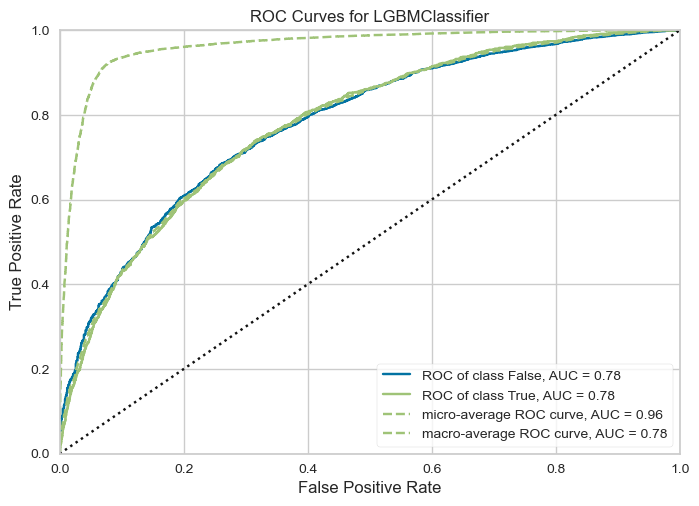

In [22]:
plot_model(tune_lightgbm, plot = 'auc')

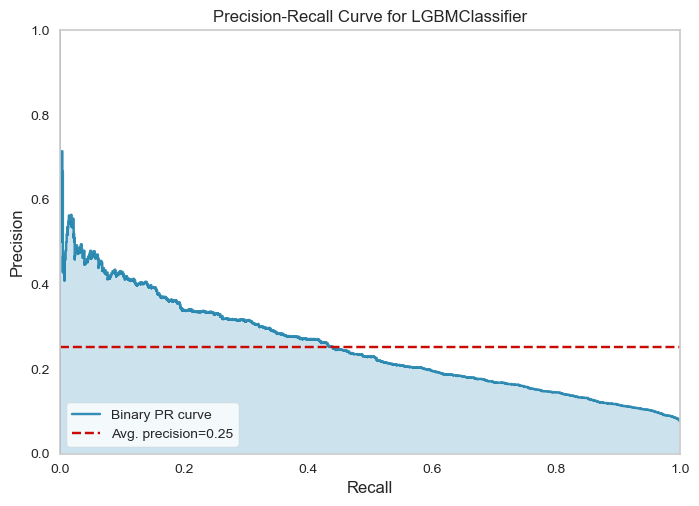

In [23]:
plot_model(tune_lightgbm, plot = 'pr')

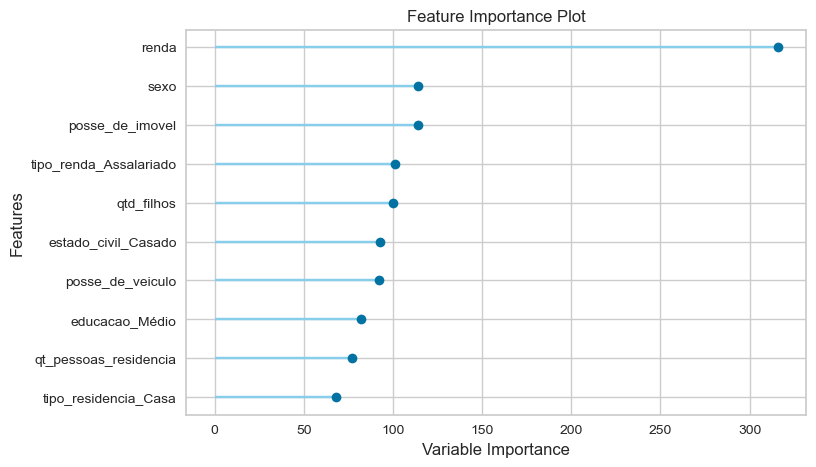

In [24]:
plot_model(tune_lightgbm, plot='feature')

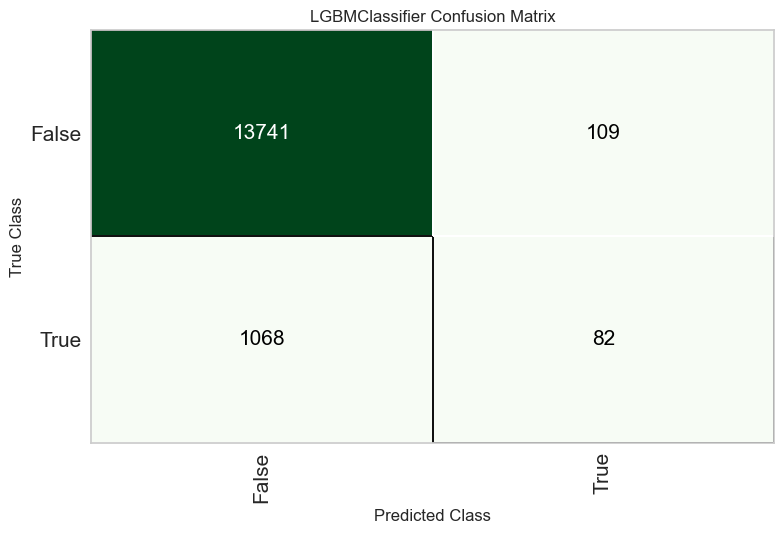

In [25]:
plot_model(tune_lightgbm, plot = 'confusion_matrix')

In [32]:
evaluate_model(tune_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [33]:
predict_model(tune_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9215,0.7807,0.0713,0.4293,0.1223,0.1027,0.1505


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
572462,M,S,S,0,Assalariado,Superior completo,Casado,Casa,50,7.660274,2.0,3203.030029,False,0,[]
459502,F,S,S,0,Pensionista,Médio,Casado,Casa,60,7.727658,2.0,13625.570312,False,0,[]
673940,F,N,S,0,Assalariado,Médio,Casado,Casa,56,6.358904,2.0,3766.409912,False,0,[]
258899,M,S,S,1,Empresário,Médio,Casado,Casa,49,1.857534,3.0,13554.759766,False,0,[]
378322,F,S,S,0,Assalariado,Médio,Separado,Casa,47,6.202740,1.0,4628.169922,False,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436665,M,S,N,0,Empresário,Médio,Separado,Com os pais,28,1.523288,1.0,19535.939453,False,0,[]
497908,M,S,S,0,Assalariado,Médio,Casado,Casa,46,5.964384,2.0,21902.140625,False,0,[]
593034,F,N,S,0,Assalariado,Médio,Casado,Casa,33,5.635616,2.0,1710.170044,False,0,[]
389782,F,N,S,0,Pensionista,Médio,União,Casa,62,7.727658,2.0,41707.039062,False,0,[]


In [34]:
final_lightgbm = finalize_model(tune_lightgbm)

save_model(tune_lightgbm,'Final ligthGBM 02Jun2023')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\Allan\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',...
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_ty